Valeurs uniques dans y: ['1.0' '2.0' '3.0' '4.0' '5.0' 'M']
Dimensions de X_train après standardisation : (700, 8)
Dimensions de X_test après standardisation : (300, 8)


c:\Users\theob\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of KNN: 79.33%
Accuracy of XGBoost: 91.67%
Accuracy of CLF: 57.00%

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76        56
           1       0.98      0.95      0.97        63
           2       0.73      0.71      0.72        58
           3       0.77      0.77      0.77        61
           4       0.72      0.77      0.74        62

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.80      0.79      0.79       300


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        56
           1       0.98      0.90      0.94        63
           2       0.95      0.95      0.95        58
           3       0.85      0.95      0.90        61
           4       0.86      0.92      0.89        62

    accuracy                           0.

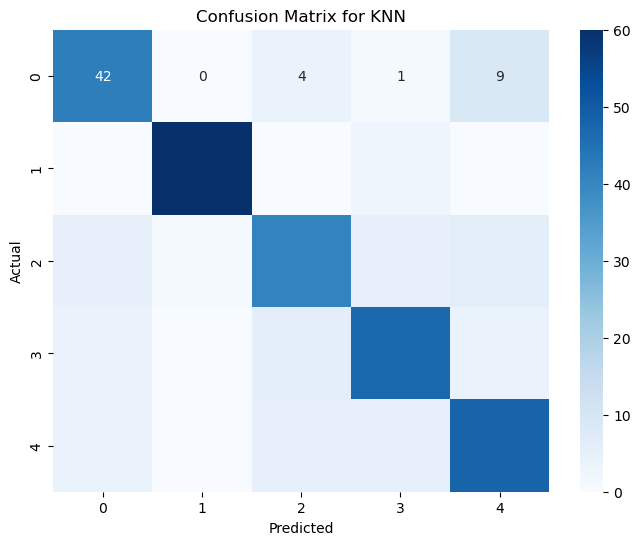

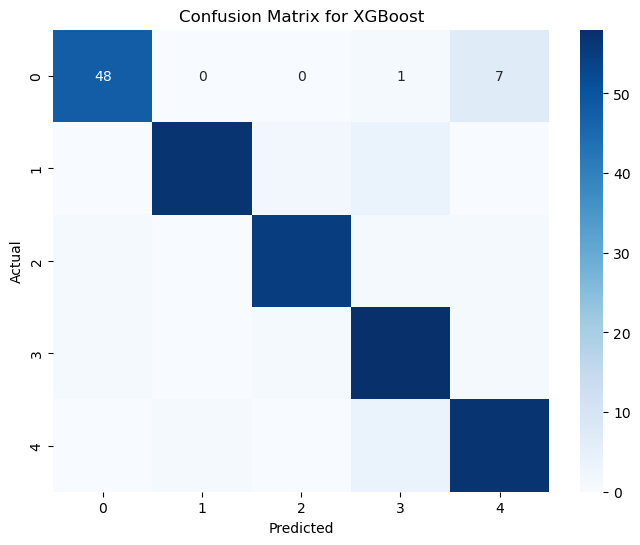

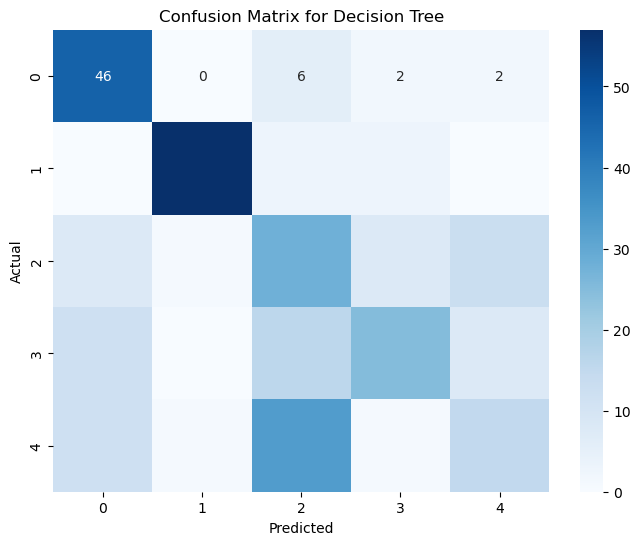

In [3]:
# Bibliothèques pour KNN et XGBoost
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données et prétraitement
data = pd.read_csv('Augmented_Mine_Dataset.csv', header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Vérifier les valeurs uniques dans y pour identifier les non-numériques
print("Valeurs uniques dans y:", np.unique(y))

# Filtrage des lignes avec des valeurs non-numériques dans y
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Filtre pour ne garder que les lignes avec des valeurs numériques dans y
mask = np.array([is_number(val) for val in y])
X = X[mask]
y = y[mask]

# Conversion des valeurs de y en entiers après avoir filtré
y = y.astype(float).astype(int)

# Correction : on réajuste les classes (y commence à 1, on la réajuste pour commencer à 0)
y = y - 1

# Indice de la colonne catégorielle dans X (assumons que c'est la dernière colonne ici, ajustez selon vos données)
categorical_features = [2]  # Par exemple, `S_original` est à l'indice 2


# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardisation des colonnes continues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification des dimensions après transformation
print("Dimensions de X_train après standardisation :", X_train_scaled.shape)
print("Dimensions de X_test après standardisation :", X_test_scaled.shape)

# 3. Création des modèles de Machine Learning

# (A) K-Nearest Neighbors (KNN) avec GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # Paramètres à tester
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_

# (B) XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Paramètres spécifiques à XGBoost
xgb.fit(X_train_scaled, y_train)

# (C) Decision Tree avec profondeur limitée
clf = tree.DecisionTreeClassifier(max_depth=5)  # Limitation de la profondeur de l'arbre
clf.fit(X_train_scaled, y_train)

# 4. Prédictions
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_clf = clf.predict(X_test_scaled)

# 5. Évaluation des performances

# Correction des calculs d'accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_clf = accuracy_score(y_test, y_pred_clf)

print(f'Accuracy of KNN: {accuracy_knn * 100:.2f}%')
print(f'Accuracy of XGBoost: {accuracy_xgb * 100:.2f}%')
print(f'Accuracy of CLF: {accuracy_clf * 100:.2f}%')

# Évaluation détaillée avec des rapports de classification (incluant F1-score et recall)
print("\nClassification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_clf))

# 6. Matrices de confusion avec visualisation


# Fonction pour tracer les matrices de confusion
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Affichage des matrices de confusion
models = {
    'KNN': y_pred_knn,
    'XGBoost': y_pred_xgb,
    'Decision Tree': y_pred_clf
}

for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)
